In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt  
import seaborn as sns
!pip install heatmapz
from heatmap import heatmap, corrplot
from sklearn.metrics import mean_squared_error

In [0]:
#cleaning the gdp dataset
gdp_df = pd.read_csv("gdp_imf.csv")
gdp_df = gdp_df.drop(columns = ["Country", "Subject Notes", "Units", "Scale", "Country/Series-specific Notes"])

transposed = gdp_df.T
transposed.head()

new_header = transposed.iloc[0] #grab the first row for the header
transposed = transposed[1:] #take the data less the header row
transposed.columns = new_header #set the header row as the df header

transposed = transposed[:-1]

transposed = transposed.reset_index() #year is no longer the index
transposed.rename(columns={transposed.columns[0]:'Year'}, inplace=True) #name the year column
transposed.rename_axis(None, axis=1, inplace = True) #remove nonsensical axis name

gdp_df = transposed #save transposed df as gdp_df

gdp_df = gdp_df[gdp_df['Year'] >= '1999'] #select only years including and after 2000
gdp_df.rename(columns = {'Year':'YEAR'}, inplace= True) #capitalize 'year'
gdp_df['YEAR'] = pd.to_numeric(gdp_df['YEAR']) #convert years to numeric

gdp_df.drop(gdp_df.columns[[1, 3, 4, 5, 7, 8]], axis = 1, inplace = True) #keep year, gdp in 2020 dollars, and unemployment rate

gdp_df.rename(columns={gdp_df.columns[1]: 'prev_gdp_billions'}, inplace = True) #rename column
gdp_df.rename(columns = {'Unemployment rate': 'prev_unemployment_rate'}, inplace= True) #rename column

gdp_df['prev_unemployment_rate'] = pd.to_numeric(gdp_df['prev_unemployment_rate'], errors='coerce')
gdp_df['prev_gdp_billions'] = pd.to_numeric(gdp_df['prev_gdp_billions'], errors='coerce')
gdp_df['prev_unemployment_rate'] = gdp_df['prev_unemployment_rate'].shift(1)
gdp_df['prev_gdp_billions'] = gdp_df['prev_gdp_billions'].shift(1)

gdp_df.drop(gdp_df.head(1).index,inplace=True) # drop first row (1999 data)

In [0]:
#cleaning the CCI data
confidence_df = pd.read_csv('oecd_consumer_confidence.csv')

confidence_df = confidence_df[confidence_df['LOCATION']== 'USA'] #only keep data for USA
confidence_df[['YEAR','MONTH']] = confidence_df.TIME.str.split("-",expand=True) #create year and month columns

confidence_df = confidence_df[(confidence_df['MONTH']== '05') & (confidence_df['YEAR'] >= '2000') & (confidence_df['YEAR'] <= '2019')] #only keep data for months of May and years 2000 through 2018

confidence_df['YEAR'] = pd.to_numeric(confidence_df['YEAR']) #convert years to int
confidence_df.drop(columns= ['MONTH', 'TIME'], inplace= True) #drop month column

confidence_df = confidence_df[['YEAR', 'Value']] #select only year and CCI value from df
confidence_df.rename(columns = {'Value':'CCI'}, inplace= True) #rename value to CCI


In [0]:
#cleaning the bills data
bills_df = pd.read_csv('HSall_rollcalls.csv')
bills_df = bills_df[['bill_number', 'date', 'yea_count', 'nay_count', 'vote_result']]

bills_df.groupby('bill_number').last() #select only the most recent vote on bill

#selecting years 2000 through 2018
years = ['2000','2001','2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009','2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
bills_df = bills_df[bills_df['date'].str.contains('|'.join(years))]

bills_df[['YEAR','MONTH', 'DAY']] = bills_df.date.str.split("-",expand=True) #create year, month, day columns
bills_df['YEAR'] = pd.to_numeric(bills_df['YEAR']) #convert years to numeric

bills_df['yn_ratio'] = bills_df['yea_count']/ bills_df['nay_count'] #create column with ratios of yea to nay votes per bill
bills_df = bills_df.replace([np.inf, -np.inf], np.nan) #replace infinite values with nan

result_combined = ['Bill Passed','Passed','Agreed to','Amendment Agreed to','Resolution Agreed to','Joint Resolution Passed', 'Concurrent Resolution Agreed to','Resolution of Ratification Agreed to', 'Veto Overridden','Failed', 'Amendment Rejected','Joint Resolution Defeated','Veto Sustained','Bill Defeated','Resolution Rejected','Concurrent Resolution Rejected','Resolution of Ratification Rejected']
result_pos = ['Bill Passed','Passed','Agreed to','Amendment Agreed to','Resolution Agreed to','Joint Resolution Passed', 'Concurrent Resolution Agreed to','Resolution of Ratification Agreed to', 'Veto Overridden']
result_neg = ['Failed', 'Amendment Rejected','Joint Resolution Defeated','Veto Sustained','Bill Defeated','Resolution Rejected','Concurrent Resolution Rejected','Resolution of Ratification Rejected']

bills_df = bills_df[bills_df['vote_result'].isin(result_combined)] #select only votes on bills and reslutions
bills_df['isPassed'] = bills_df['vote_result'].isin(result_pos)*1 #create binary column indicating if vote passed

bills_df_passed = bills_df.groupby(['YEAR'])['isPassed'].sum().reset_index() #count the number of bills passed
bills_df_yn_ratio= bills_df.groupby(['YEAR'])['yn_ratio'].mean().reset_index() #calculate mean ratio of yea to nay votes

yn_ratio_series = bills_df_yn_ratio['yn_ratio'] #create series from yn_ratio column
bills_df = pd.concat([bills_df_passed, yn_ratio_series], axis=1) #concatenate yn_ratio series to the bills dataframe
bills_df.rename(columns = {'isPassed':'bills_passed'}, inplace= True) #rename isPassed to indicate this column is now number of bills passed

In [0]:
#cleaning the BLS data
bls1999_2018 = pd.read_csv('1999_2018_merged_clean.csv', engine= 'python')

bls1999_2018 = bls1999_2018.iloc[:,1:] #remove extraneous first column
bls1999_2018 = bls1999_2018.drop(columns = 'AREA_NAME') #remove area name
bls1999_2018 = bls1999_2018.replace(['#','*','**', '***'], np.nan) #replace nonsense values with NaN

bls1999_2018['YEAR'] = pd.to_numeric(bls1999_2018['YEAR']) #convert year to numeric
bls1999_2018['H_MEAN'] = pd.to_numeric(bls1999_2018['H_MEAN']) #convert hourly mean wage to numeric
bls1999_2018['A_MEAN'] = pd.to_numeric(bls1999_2018['A_MEAN']) #convert annual mean salary to numeric
bls1999_2018['H_MEDIAN'] = pd.to_numeric(bls1999_2018['H_MEDIAN']) #convert hourly median wage to numeric
bls1999_2018['A_MEDIAN'] = pd.to_numeric(bls1999_2018['A_MEDIAN']) #convert hourly median salary to numeric

bls1999_2018 = bls1999_2018.groupby(['YEAR', 'PRIM_STATE']).agg({'TOT_EMP': np.sum,'H_MEAN': np.mean, 'A_MEAN': np.mean,'H_MEDIAN': np.mean, 'A_MEDIAN': np.mean}).reset_index()
bls1999_2018['del_tot_emp'] = bls1999_2018.groupby('PRIM_STATE')['TOT_EMP'].diff()  #create column for year-to-year change in total employment
bls1999_2018 = bls1999_2018[bls1999_2018['YEAR'] > 1999] #drop 1999 data

In [0]:
#merge dataframes
full_df = pd.merge(left=bills_df, right=confidence_df)
full_df = pd.merge(left=full_df, right=gdp_df)
full_df = pd.merge(left=full_df, right=bls1999_2018)
full_df.drop(['TOT_EMP'],axis=1, inplace=True) #drop total employment from df

full_df.head()

,YEAR,bills_passed,yn_ratio,CCI,prev_gdp_billions,prev_unemployment_rate,PRIM_STATE,H_MEAN,A_MEAN,H_MEDIAN,A_MEDIAN,del_tot_emp
0,2000,526,34.818157,102.5414,9630.7,4.217,AK,19.963314,41484.505814,19.211144,39909.825581,29050.0
1,2000,526,34.818157,102.5414,9630.7,4.217,AL,14.865863,31296.266335,14.097633,29738.921446,117740.0
2,2000,526,34.818157,102.5414,9630.7,4.217,AR,13.962078,29246.637168,13.207926,27708.616224,57120.0
3,2000,526,34.818157,102.5414,9630.7,4.217,AZ,15.707516,33104.177719,14.876035,31314.233577,184060.0
4,2000,526,34.818157,102.5414,9630.7,4.217,CA,18.343374,38687.859601,17.464243,36886.882260,1451260.0


In [0]:
#create dummy features of states
dummy_states = pd.get_dummies(full_df['PRIM_STATE']) #create dummy variables for states in df
full_df.drop(columns = 'PRIM_STATE', inplace= True) #drop the state column from df
full_df = pd.concat([full_df, dummy_states], axis = 1) #concatenate dummy states to df

#Plots

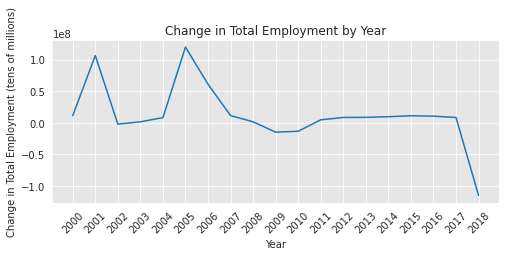

In [0]:
#generate plot of total employment by year
df_to_plot = full_df.groupby(['YEAR']).agg({'del_tot_emp': np.sum}).reset_index() #create df with only years and employment numbers

years =  list(range(2000, 2019))

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8, 3))
plt.plot(years, df_to_plot['del_tot_emp']);
plt.xticks(years, rotation = 45);
plt.xlabel('Year');
plt.ylabel('Change in Total Employment (tens of millions)');
plt.title('Change in Total Employment by Year');
plt.show()

Text(0.5, 0, 'Annual Change in Total Employment (in millions of people)')

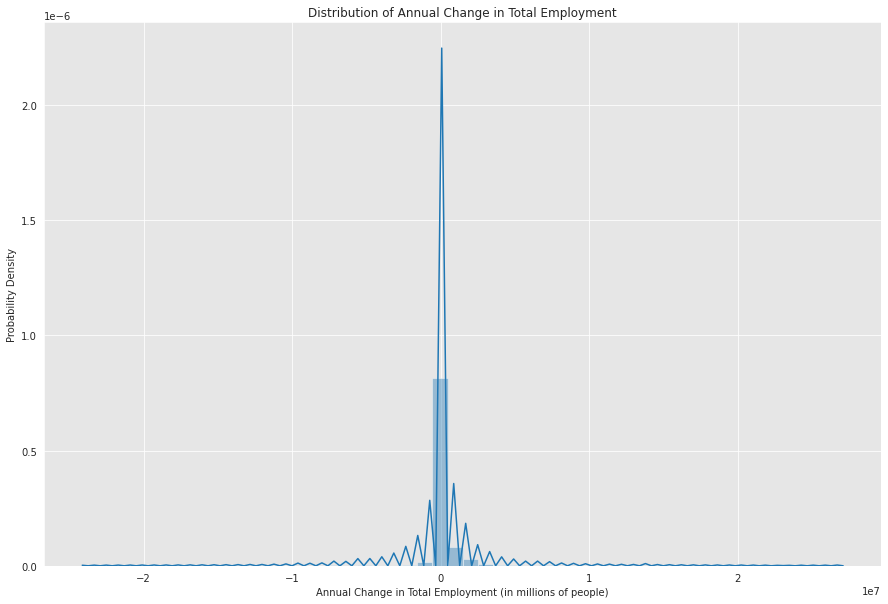

In [0]:
#plotting Annual Change in Total Employment distribution
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Annual Change in Total Employment')  
plt.ylabel('Probability Density') 
sns.distplot(full_df['del_tot_emp'])
plt.xlabel('Annual Change in Total Employment (in millions of people)') 

Text(0.5, 0, "Previous Year's GDP (billions of dollars)")

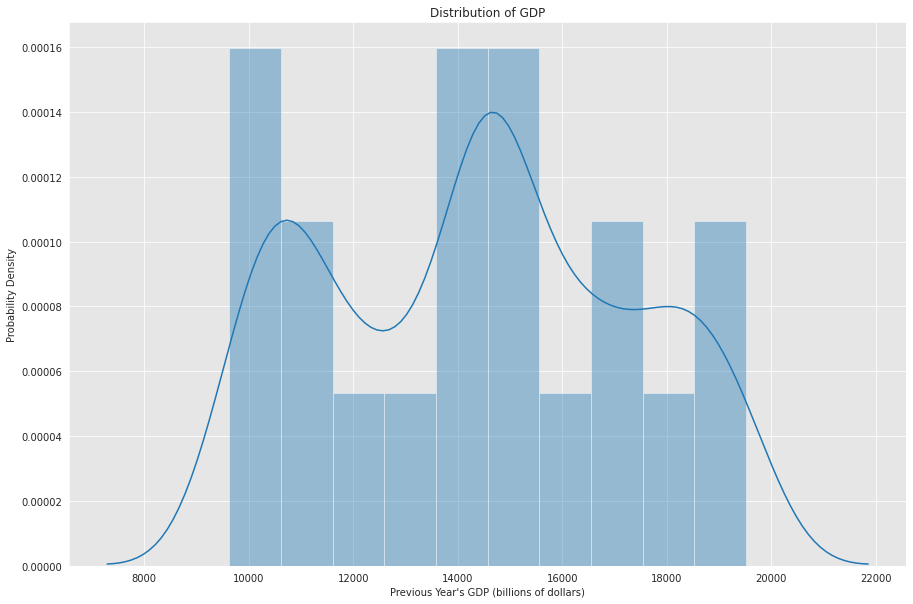

In [0]:
#plotting GDP distribution
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of GDP') 
plt.ylabel('GDP (in billions of Dollars)') 
plt.ylabel('Probability Density')
sns.distplot(full_df['prev_gdp_billions'])
plt.xlabel("Previous Year's GDP (billions of dollars)") 

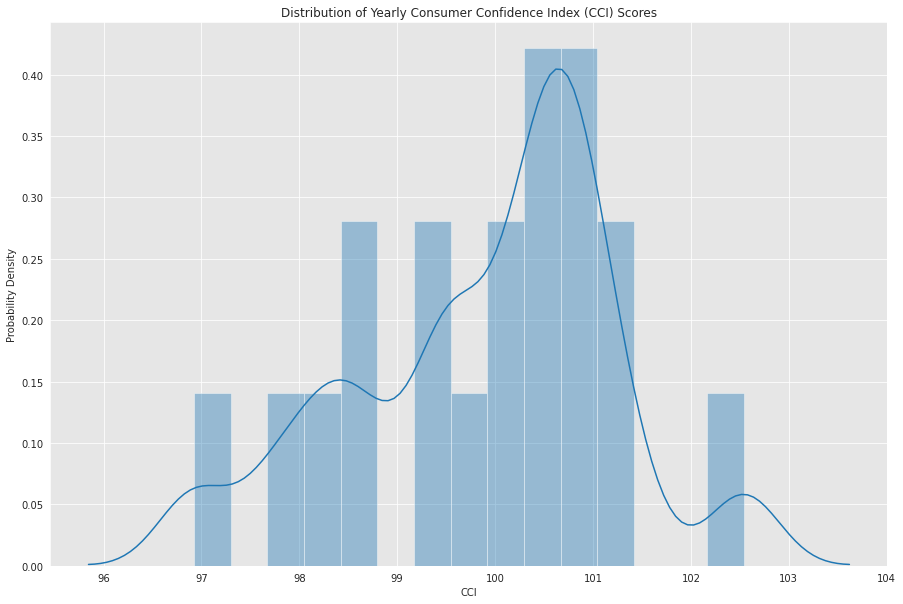

In [0]:
#plotting CCI distribution
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Yearly Consumer Confidence Index (CCI) Scores')  
plt.ylabel('Probability Density') 
sns.distplot(full_df['CCI'])

Text(0.5, 0, 'Bills Passed')

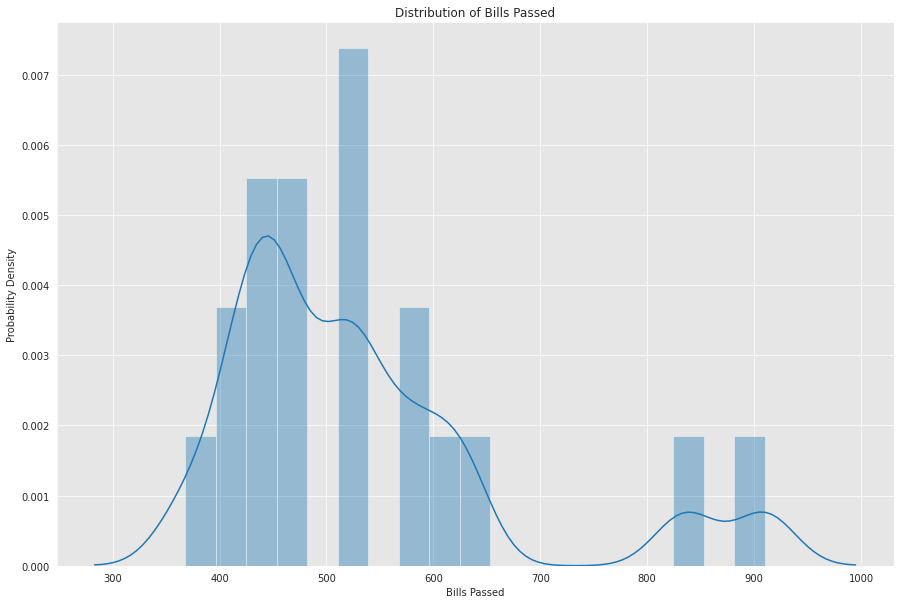

In [0]:
#plotting bills passed distribution
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Bills Passed')  
plt.ylabel('Probability Density') 
sns.distplot(full_df['bills_passed'])
plt.xlabel('Bills Passed') 

Text(0.5, 0, 'Yea to Nay Vote Ratio')

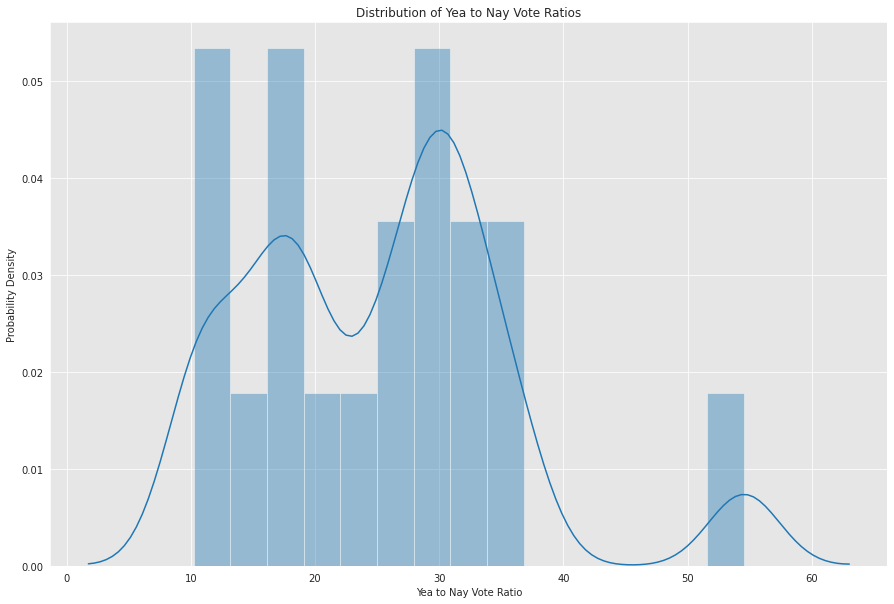

In [0]:
#plotting yea to nay distribution
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title('Distribution of Yea to Nay Vote Ratios')  
plt.ylabel('Probability Density') 
sns.distplot(full_df['yn_ratio'])
plt.xlabel("Yea to Nay Vote Ratio") 

Text(0.5, 0, "Previous Year's Unemployment Rate")

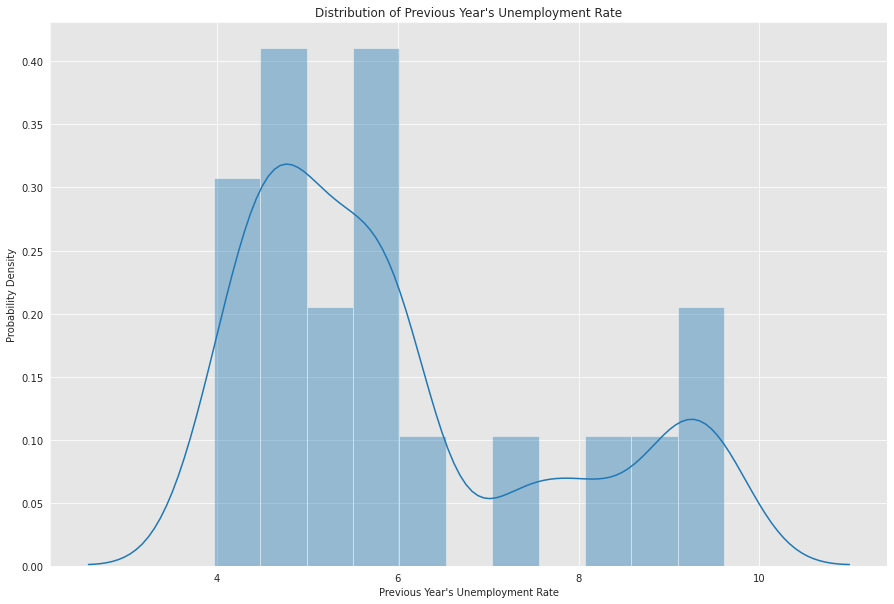

In [0]:
#plotting previous year's unemployment rate distribution
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.title("Distribution of Previous Year's Unemployment Rate")  
plt.ylabel('Probability Density') 
sns.distplot(full_df['prev_unemployment_rate'])
plt.xlabel("Previous Year's Unemployment Rate") 

First Linear Regression Model

#Linear Regression

In [0]:
#generating first linear regression model

scaler = MinMaxScaler()

relevant_columns = ['YEAR',	'bills_passed',	'yn_ratio',	'CCI',	'prev_gdp_billions','prev_unemployment_rate',	'H_MEAN',	'A_MEAN',	'H_MEDIAN',	'A_MEDIAN', 'del_tot_emp'] #used in corr plot
to_scale = full_df.columns	

scaler.fit(full_df[to_scale]) #Transform indexes to min max scaling
full_df[to_scale]=scaler.transform(full_df[to_scale]) #overwrite df values with rescaled values

y = full_df['del_tot_emp']
X = full_df.drop(['del_tot_emp'],axis=1) #drop total employment from df

# Fit and summarize OLS model
mod = sm.OLS(y, X).fit()
y_pred = mod.predict(X)

print(mod.summary()) #notice the coefficient for dem_rep_ratio is miniscule when looking at cases/population
print(" ")
print("Multicolinearity Condition Number:", np.linalg.cond(mod.model.exog))
print(" ")
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, y_pred)))


                            OLS Regression Results                            
Dep. Variable:            del_tot_emp   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.822
Date:                Thu, 07 May 2020   Prob (F-statistic):           0.000185
Time:                        22:22:21   Log-Likelihood:                 1828.4
No. Observations:                 988   AIC:                            -3533.
Df Residuals:                     926   BIC:                            -3229.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
YEAR                       0

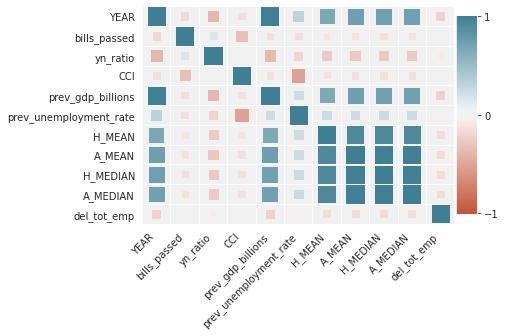

In [0]:
#heatmap code source: https://github.com/drazenz/heatmap/blob/master/heatmap/heatmap.py

def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order', 'xlabel', 'ylabel'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    ax.set_xlabel(kwargs.get('xlabel', ''))
    ax.set_ylabel(kwargs.get('ylabel', ''))

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index').replace(np.nan, 0)
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )
corrplot(full_df[relevant_columns].corr(), size_scale=300);

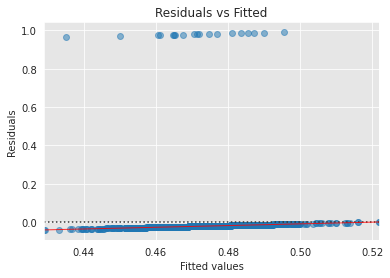

In [0]:
#generating plot of residuals

model_fitted_y = mod.fittedvalues

#generate model residuals
model_residuals = mod.resid

#generate normalized residuals
model_norm_residuals = mod.get_influence().resid_studentized_internal

#generate absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

#generate absolute residuals
model_abs_resid = np.abs(model_residuals)

#calculate leverage
model_leverage = mod.get_influence().hat_matrix_diag

#calculate cook's distance
model_cooks = mod.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, full_df.columns[-1], data=full_df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

Second Linear Regression Model

In [0]:
#generating second linear regression model

df_model2 = full_df[['YEAR',	'bills_passed',	'yn_ratio',	'CCI',	'prev_gdp_billions','prev_unemployment_rate',	'H_MEAN',	'A_MEAN',	'H_MEDIAN',	'A_MEDIAN', 'del_tot_emp']]
relevant_columns = ['YEAR',	'bills_passed',	'yn_ratio',	'CCI',	'prev_gdp_billions','prev_unemployment_rate',	'H_MEAN',	'A_MEAN',	'H_MEDIAN',	'A_MEDIAN', 'del_tot_emp'] #used in corr plot

y = df_model2['del_tot_emp']
X = df_model2.drop(columns = 'del_tot_emp', axis = 1)

# Fit and summarize OLS model
mod = sm.OLS(y, X).fit()
y_pred = mod.predict(X)

print(mod.summary()) #notice the coefficient for dem_rep_ratio is miniscule when looking at cases/population
print(" ")
print("Multicolinearity Condition Number:", np.linalg.cond(mod.model.exog))
print(" ")
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, y_pred)))

                                 OLS Regression Results                                
Dep. Variable:            del_tot_emp   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              4142.
Date:                Thu, 07 May 2020   Prob (F-statistic):                        0.00
Time:                        22:22:23   Log-Likelihood:                          1191.1
No. Observations:                 988   AIC:                                     -2362.
Df Residuals:                     978   BIC:                                     -2313.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

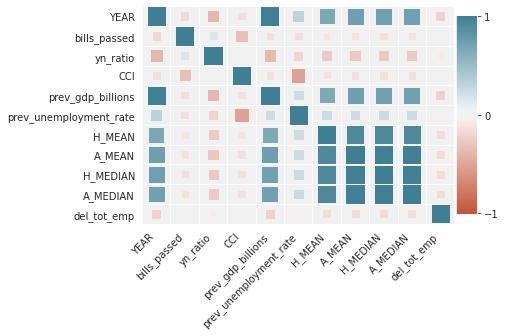

In [0]:
corrplot(df_model2[relevant_columns].corr(), size_scale=300);

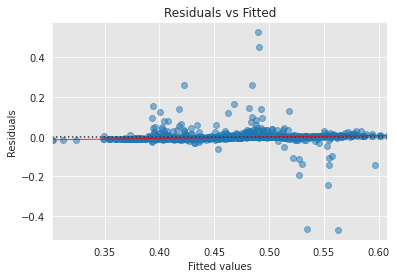

In [0]:
#generating plot of residuals

model_fitted_y = mod.fittedvalues

#generate model residuals
model_residuals = mod.resid

#generate normalized residuals
model_norm_residuals = mod.get_influence().resid_studentized_internal

#generate absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

#generate absolute residuals
model_abs_resid = np.abs(model_residuals)

#calculate leverage
model_leverage = mod.get_influence().hat_matrix_diag

#calculate cook's distance
model_cooks = mod.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, df_model2.columns[-1], data=df_model2,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [0]:
#generating third linear regression model
relevant_columns = ['YEAR',	'bills_passed',	'yn_ratio',	'CCI', 'prev_gdp_billions', 'prev_unemployment_rate', 'A_MEDIAN', 'del_tot_emp']

y = full_df['del_tot_emp']
X = full_df[relevant_columns]

# Fit and summarize OLS model
mod = sm.OLS(y, X).fit()
y_pred = mod.predict(X)

print(mod.summary())
print(" ")
print("Multicolinearity Condition Number:", np.linalg.cond(mod.model.exog))
print(" ")
print("Mean Squared Error:", mean_squared_error(y, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y, y_pred)))

                                 OLS Regression Results                                
Dep. Variable:            del_tot_emp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.594e+31
Date:                Thu, 07 May 2020   Prob (F-statistic):                        0.00
Time:                        22:22:24   Log-Likelihood:                          32848.
No. Observations:                 988   AIC:                                 -6.568e+04
Df Residuals:                     980   BIC:                                 -6.564e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

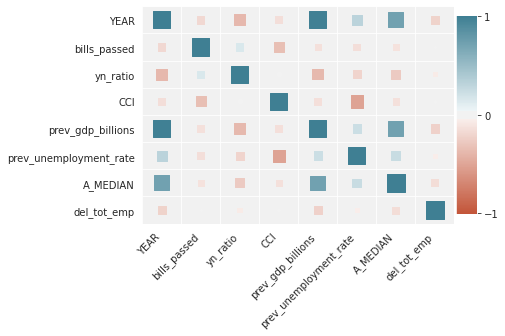

In [0]:
corrplot(full_df[relevant_columns].corr(), size_scale=300);

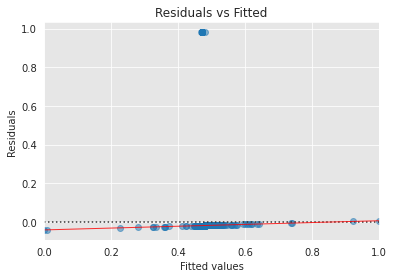

In [0]:
#generating plot of residuals

model_fitted_y = mod.fittedvalues

#generate model residuals
model_residuals = mod.resid

#generate normalized residuals
model_norm_residuals = mod.get_influence().resid_studentized_internal

#generate absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

#generate absolute residuals
model_abs_resid = np.abs(model_residuals)

#calculate leverage
model_leverage = mod.get_influence().hat_matrix_diag

#calculate cook's distance
model_cooks = mod.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, full_df.columns[-1], data=full_df,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');